We are using R for analysis.


In [18]:
#packages
install.packages("forecast")
library(rmgarch)
library(lmtest)
library(tseries)
library(forecast)
library(repr)
library(rugarch) # package for GARCH modelling
#library(moments) # package for kurtosis estimation
library(aTSA) # package for ARCH-LM test

also installing the dependencies ‘fracdiff’, ‘timeDate’





The downloaded binary packages are in
	/var/folders/cq/c7xlssj5225bwykswpmw_bj40000gn/T//Rtmp4DFRCI/downloaded_packages


Warning message:
“package ‘forecast’ was built under R version 4.3.3”

Attaching package: ‘forecast’


The following object is masked from ‘package:aTSA’:

    forecast




In [19]:
data <- read.csv("Microsoft_data.csv")
data <- data[-c(1:2), ]

# Rename column 'price' to 'Date'
names(data)[names(data) == "Price"] <- "Date"
names(data)[names(data) == "Adj.Close"] <- "Price"
data <- data[, -c(3:7)]
data$Price <- as.numeric(data$Price)
head(data)

,Date,Price
,<chr>,<dbl>
3,2010-01-04,23.25406
4,2010-01-05,23.26156
5,2010-01-06,23.11880
6,2010-01-07,22.87838
7,2010-01-08,23.03616
8,2010-01-11,22.74315


In [20]:
data$log_ret <- c(NA, diff(log(data$Price)))
data <- na.omit(data)
length(data$log_ret)
# omit NAs
log_ret = na.omit(data$log_ret)
length(data$log_ret)
head(data)

[1] 3313

[1] 3313

,Date,Price,log_ret
,<chr>,<dbl>,<dbl>
4,2010-01-05,23.26156,0.0003227053
5,2010-01-06,23.11880,-0.0061558790
6,2010-01-07,22.87838,-0.0104538339
7,2010-01-08,23.03616,0.0068727811
8,2010-01-11,22.74315,-0.0128014351
9,2010-01-12,22.59287,-0.0066294634


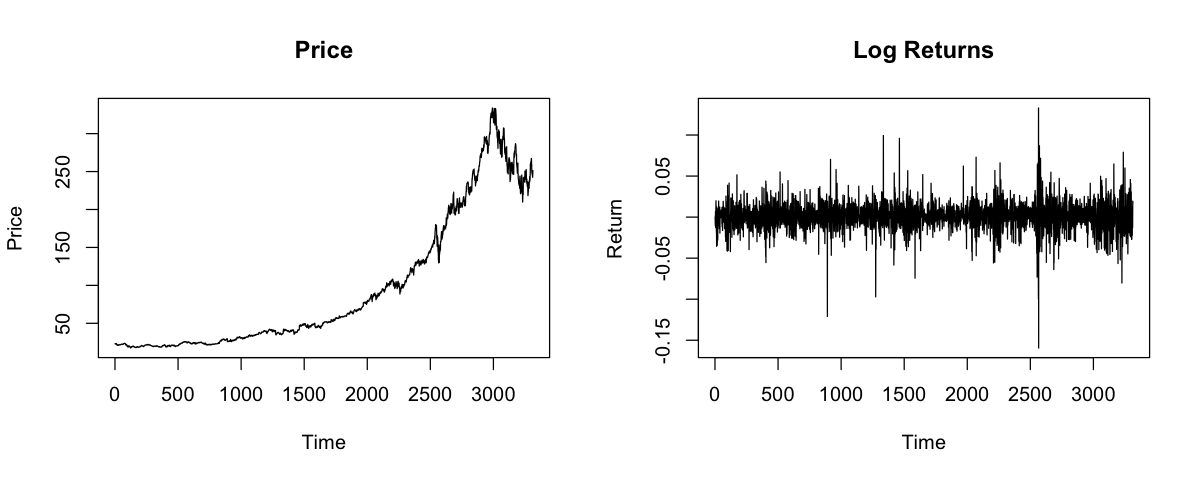

In [21]:
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow = c(1,2))

# Original Price
ts.plot(data$Price, col = "black", main = "Price", ylab = "Price", xlab = "Time")

# Log Returns (if available)
ts.plot(data$log_ret, col = "black", main = "Log Returns", ylab = "Return", xlab = "Time")

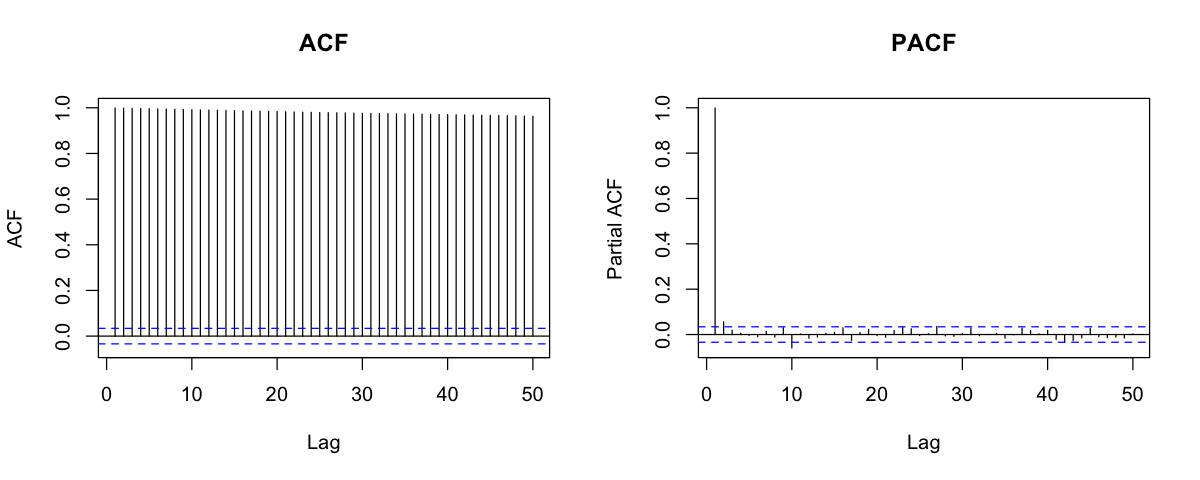

In [22]:
par(mfrow = c(1,2))
Acf(data$Price, lag.max = 50, main = "ACF")
Pacf(data$Price, lag.max = 50, main = "PACF")

We can see that price is not stationary variables

In [23]:
tseries::adf.test(data$Price)


	Augmented Dickey-Fuller Test

data:  data$Price
Dickey-Fuller = -1.7914, Lag order = 14, p-value = 0.6667
alternative hypothesis: stationary


Warning message in tseries::adf.test(data$log_ret):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data$log_ret
Dickey-Fuller = -15.89, Lag order = 14, p-value = 0.01
alternative hypothesis: stationary


KPSS Unit Root Test 
alternative: nonstationary 
 
Type 1: no drift no trend 
 lag stat p.value
  13 2.89    0.01
----- 
 Type 2: with drift no trend 
 lag  stat p.value
  13 0.195     0.1
----- 
 Type 1: with drift and trend 
 lag  stat p.value
  13 0.107     0.1
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 


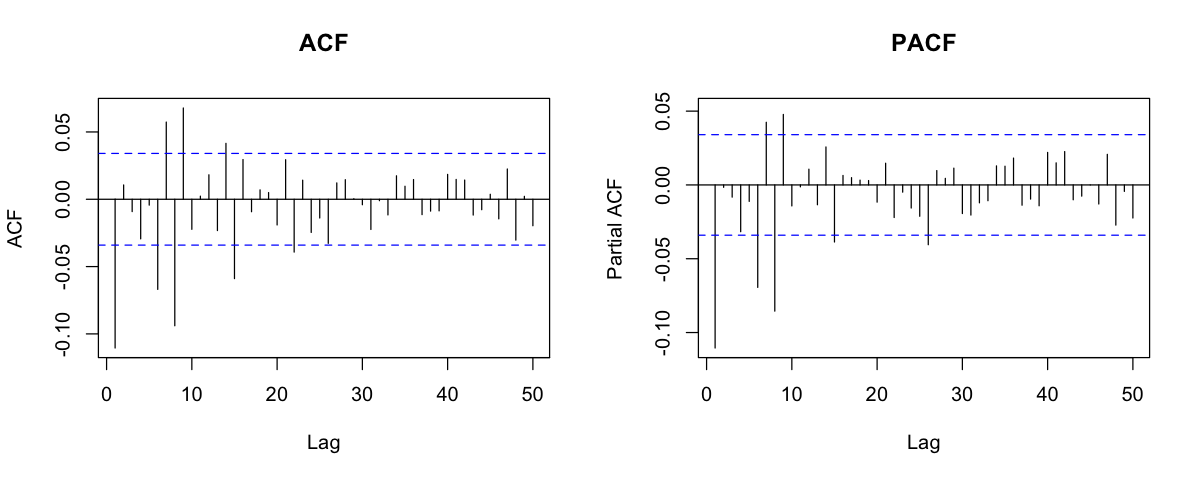

In [24]:
# ACF PACF plots
par(mfrow = c(1,2))
Acf(data$log_ret, lag.max = 50, main = "ACF")
Pacf(data$log_ret, lag.max = 50, main = "PACF")

#ADF test
tseries::adf.test(data$log_ret)

#KPSS test
kpss.test(data$log_ret)

Series: data$log_ret 
ARIMA(0,0,1) with zero mean 

Coefficients:
          ma1
      -0.1073
s.e.   0.0171

sigma^2 = 0.0002673:  log likelihood = 8927.67
AIC=-17851.33   AICc=-17851.33   BIC=-17839.12


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with zero mean
Q* = 59.238, df = 9, p-value = 1.88e-09

Model df: 1.   Total lags used: 10



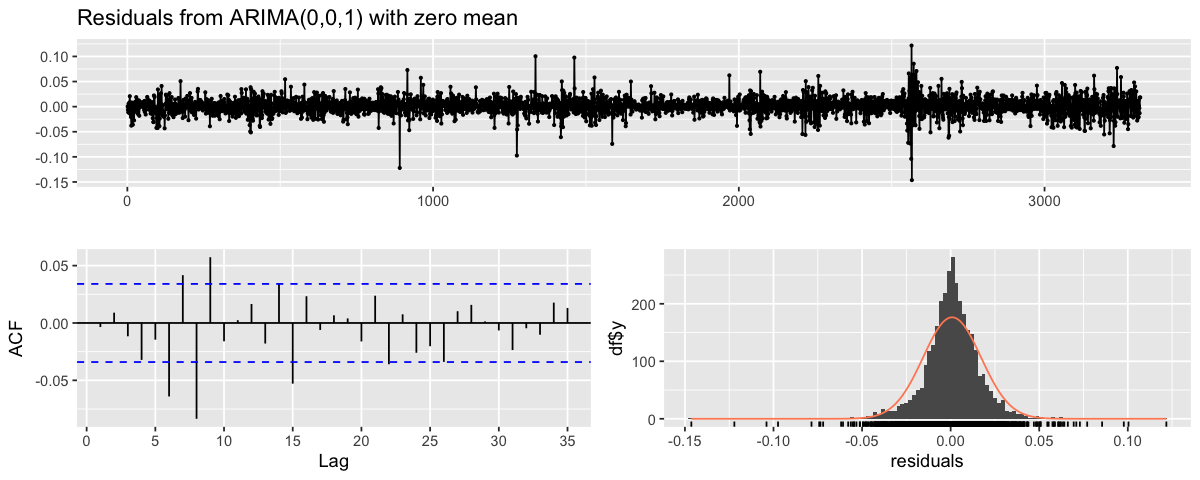

In [25]:
(fit_auto <- auto.arima(data$log_ret, ic = c("bic"), stationary = TRUE))
checkresiduals(fit_auto)

In [26]:
Box.test(fit_auto$residuals, lag = 20, type = c("Ljung-Box"))


	Box-Ljung test

data:  fit_auto$residuals
X-squared = 77.393, df = 20, p-value = 1.083e-08


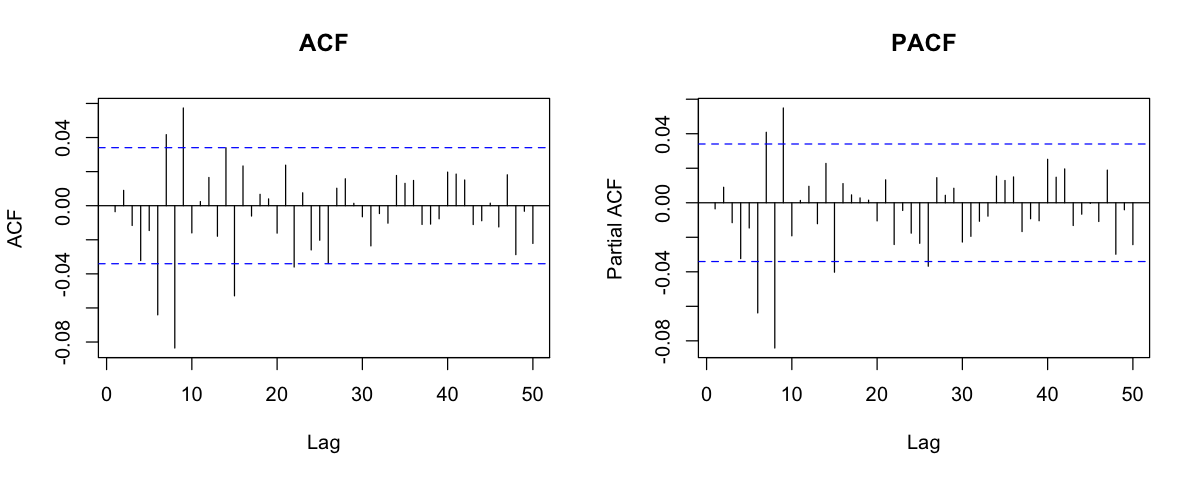

In [27]:
par(mfrow = c(1,2))
Acf(fit_auto$residuals, lag.max = 50, main = "ACF")
Pacf(fit_auto$residuals, lag.max = 50, main = "PACF")

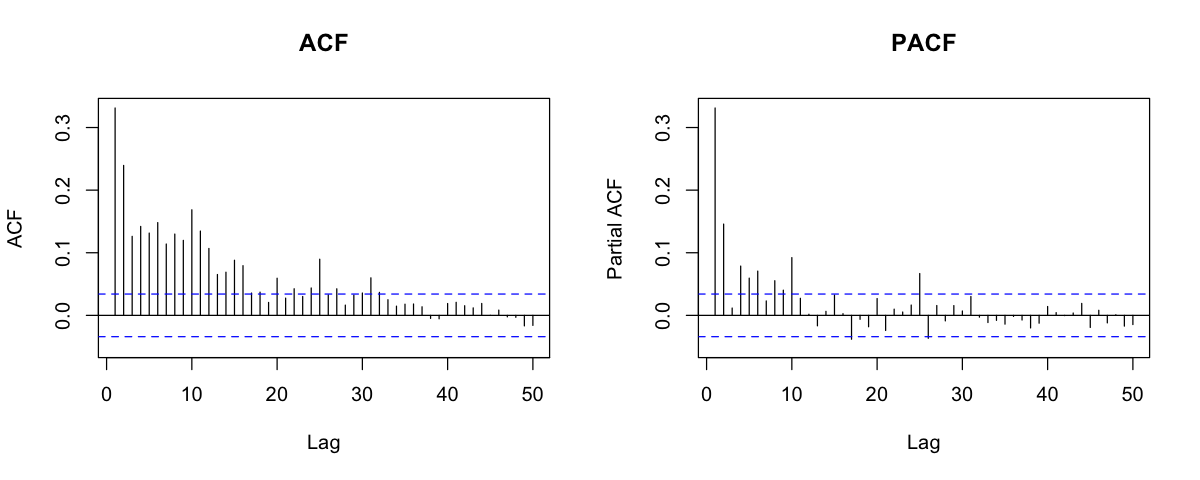

In [28]:
resid <- fit_auto$residuals
resid_sqrd <- resid^2 # create squared residuals
par(mfrow = c(1,2))
Acf(resid_sqrd, lag.max = 50, main = "ACF")
Pacf(resid_sqrd, lag.max = 50, main = "PACF")

ARCH heteroscedasticity test for residuals 
alternative: heteroscedastic 

Portmanteau-Q test: 
     order   PQ p.value
[1,]     4  676       0
[2,]     8  904       0
[3,]    12 1142       0
[4,]    16 1218       0
[5,]    20 1239       0
[6,]    24 1257       0
Lagrange-Multiplier test: 
     order   LM p.value
[1,]     4 2653       0
[2,]     8 1232       0
[3,]    12  770       0
[4,]    16  573       0
[5,]    20  454       0
[6,]    24  375       0


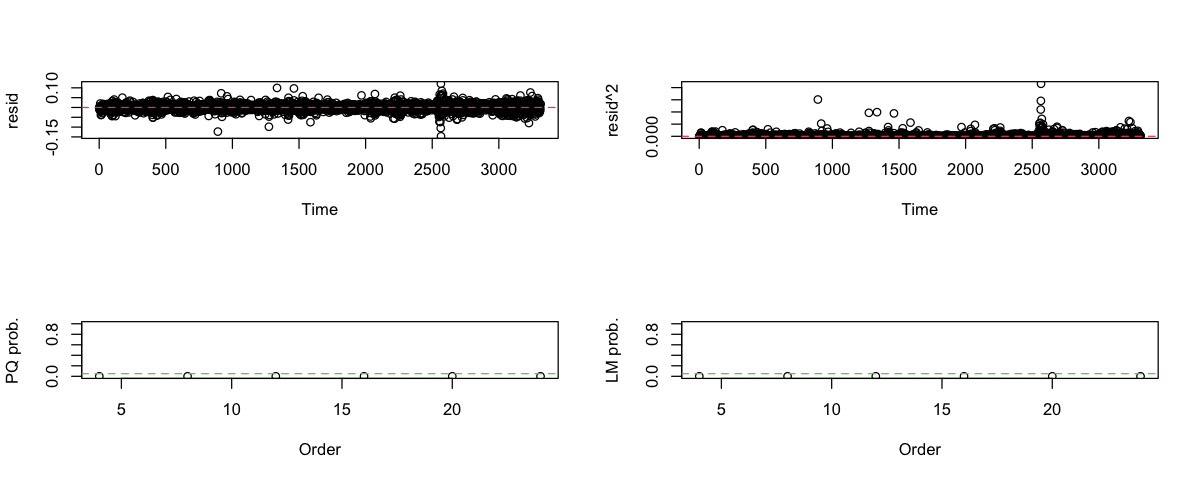

In [29]:
arch.test(arima(data$log_ret,order = c(0,0,1)))

In [30]:

ArchTest(resid, lags = 12, demean = FALSE)

ERROR: Error in library(FinTS): there is no package called ‘FinTS’


Now we are sure that there are ARCH/GARCH effects present in our Data

In [62]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 1), include.mean = TRUE), 
                      variance.model = list(garchOrder = c(1, 1)))

# estimate the model
fit <- ugarchfit(spec = model_specification, data = data$log_ret)
#infocriteria(fit)


coef(fit)
fit


mu           ma1         omega        alpha1         beta1 
 1.031818e-03 -4.365361e-02  1.871796e-05  1.292431e-01  8.032875e-01


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001032    0.000230   4.4929 0.000007
ma1    -0.043654    0.020019  -2.1806 0.029210
omega   0.000019    0.000004   4.7125 0.000002
alpha1  0.129243    0.021721   5.9501 0.000000
beta1   0.803288    0.032044  25.0681 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001032    0.000225   4.5769 0.000005
ma1    -0.043654    0.022324  -1.9554 0.050531
omega   0.000019    0.000009   2.0194 0.043443
alpha1  0.129243    0.045808   2.8214 0.004781
beta1   0.803288    0.071026  11.3097 0.000000

LogLikelihood : 9212.841 

Information Criteria
------------------------------------
                

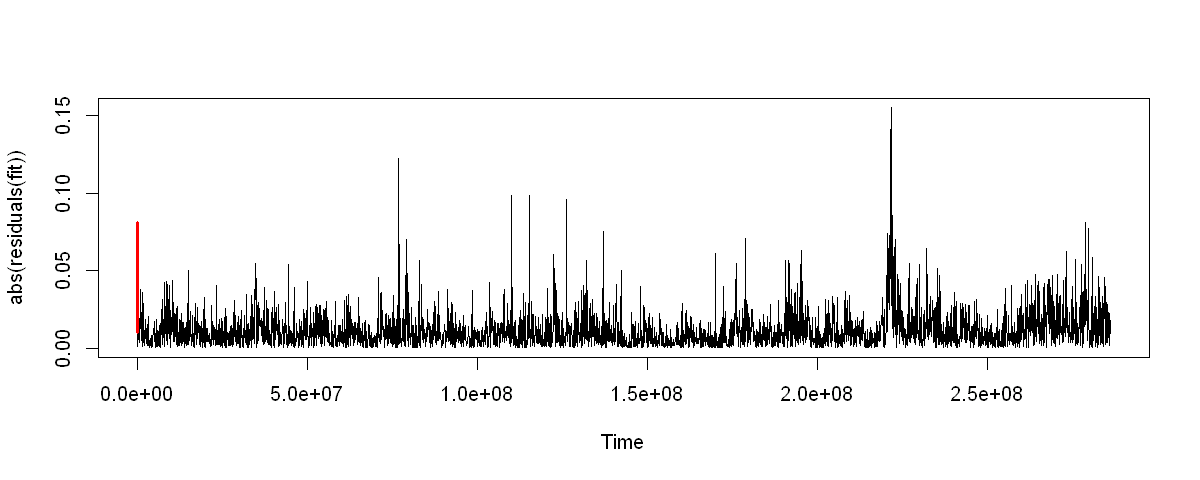

In [64]:
#plot.ts(abs(log_ret))
plot.ts(abs(residuals(fit))) # residuals (after fitting arma model) or log_ret in absolute values
lines(as.numeric(sigma(fit)),col = "red", lwd = 3) 
# plot of the residuals/log returns in absolute value and of estimated conditional standard deviation (volatility)